<a href="https://colab.research.google.com/github/Sagnik-Nandi/PDFQueryBot---Chatbot-over-PDFs-using-RAG/blob/main/assnmt%201%20-%20Digit%20recognition%20using%20Pytorch/digit_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset

## Imports and Data Exploration
- Importing pytorch and other libs
- Create dataset and dataloader instances


In [55]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [56]:
# Loading the dataset
train=datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)
test=datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])
)

In [57]:
# Some idea about the dataset
print(train)
print(test)
print(train[0][0].shape)
print(train[0][1])

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )
torch.Size([1, 28, 28])
5


## Train and validation split   
- create dataloader instances for each dataset
- Hyperparameter used:
1. Batch_size = 8   
Reducing batch_size significantly improved accuracy, but too small batch_size makes the model computationally large and unstable
- train-validation split ratio = 11:1   
(changing split ratio did not affect accuracy much)

In [58]:
trainAll=train
train, eval=random_split(trainAll, [55000, 5000])

# Hyperparameter: Batch_size
batch_size=8

# Dataloader for : train, eval, test
train_loader=torch.utils.data.DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True,
  )
eval_loader=torch.utils.data.DataLoader(
    eval,
    batch_size=batch_size,
    shuffle=True,
  )
test_loader=torch.utils.data.DataLoader(
    test,
    batch_size=batch_size,
    shuffle=True,
  )


In [59]:
# REF: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
# Shows sample images from the dataset using plt.imshow
def visualizeSample(data):
  figure = plt.figure(figsize=(8, 8))
  cols, rows = 3, 3
  for i in range(1, cols * rows + 1):
      sample_idx = torch.randint(len(data), size=(1,)).item()
      img, label = data[sample_idx]
      figure.add_subplot(rows, cols, i)
      plt.title(label)
      plt.axis("off")
      plt.imshow(img.squeeze(), cmap="gray")
  plt.show()
# visualizeSample(train)

# Make a Neural Network model


- Create model and forward function   
- The model consists of: input layer(size 28*28), 1 hidden layer(size 32), and output layer(size 10)   
(output layer has 10 values, for i in (0, 9) : Pr(input==i). The one having highest probability corresponds to the identified digit)
- ReLU Activation function and Batch Normalization are used to enhance performance
- Hyperparameters used:
2. no. of hidden layers = 1   
(increasing hidden layers does not improve accuracy)
2. no. of units in layer1 = 32   
(changing number of units does not affect accuracy)

In [60]:
from torch import nn

class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten() # flattens 28*28 2d array to 1d vector
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, 10),
        )

    def forward(self, x): # forward propagation function
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


model=NeuralNetwork()

## Training and testing
 - Hyperparameters used:
4. learning_rate = 0.001   
  Critical parameter
5. epoch = 10 (for testing and tuning purposes, set to 5)   
  Critical parameter, increasing no. of epochs improved accuracy. But too large no. of epochs can be computaionally large and may lead to overfitting

- Loss Function   
Cross Entropy function is generally suitable in discrete-valued prediction problem, such as this one

- Optimizer   
Optimizer compiles the backward propagation step and update the parameters based on different algorithms, such as Gradient Descent   
Tested with different ones like SGD(Stochastic Gradient Descent), ADAM() etc.

In [61]:
# Hyperparameters:
learning_rate = 1e-3
# batch_size = 8
epochs = 10

loss_fn = nn.CrossEntropyLoss()
# optimizer0 = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, amsgrad=True)

In [62]:
# REF: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html

def train_loop(dataloader, model, loss_fn, optimizer, verbose=True):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss=0
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss+=loss.item()

        # Backpropagation, update parameters and reset all the gradients to zero
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Show progress report :D
        if verbose and batch % 500 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"Training Loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
    train_loss/=num_batches
    return train_loss

def eval_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    valid_loss, correct = 0, 0

    # torch.no_grad() ensures that no gradients are computed during eval mode
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            valid_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    valid_loss /= num_batches
    correct /= size
    print(f"Validation Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {valid_loss:>8f} \n")
    return valid_loss



Epoch 1
-------------------------------
Training Loss: 2.277845  [    8/55000]
Training Loss: 0.897020  [ 4008/55000]
Training Loss: 0.900373  [ 8008/55000]
Training Loss: 0.150516  [12008/55000]
Training Loss: 0.766362  [16008/55000]
Training Loss: 0.890005  [20008/55000]
Training Loss: 0.211063  [24008/55000]
Training Loss: 0.208256  [28008/55000]
Training Loss: 1.338091  [32008/55000]
Training Loss: 0.486937  [36008/55000]
Training Loss: 0.683779  [40008/55000]
Training Loss: 0.246016  [44008/55000]
Training Loss: 0.148156  [48008/55000]
Training Loss: 0.086736  [52008/55000]
Validation Error: 
 Accuracy: 93.2%, Avg loss: 0.228895 

Validation Loss Decreased(inf--->0.228895) 
 Saving The Model

Epoch 2
-------------------------------
Training Loss: 0.086850  [    8/55000]
Training Loss: 0.597839  [ 4008/55000]
Training Loss: 0.591598  [ 8008/55000]
Training Loss: 0.114660  [12008/55000]
Training Loss: 0.200447  [16008/55000]
Training Loss: 0.018759  [20008/55000]
Training Loss: 0.31

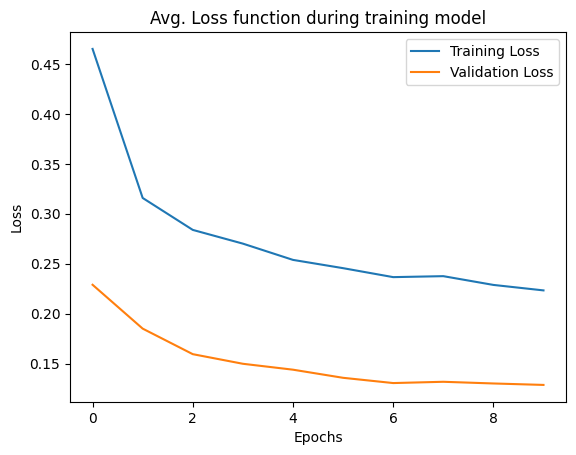

Done!


In [63]:
# REF: https://www.geeksforgeeks.org/training-neural-networks-with-validation-using-pytorch/

def fit(model, epochs, train_loader, eval_loader, loss_fn, optimizer, verbose=True, plot_loss=True):
  min_valid_loss = np.inf
  train_loss_data = [] # tracks loss data over all epochs
  valid_loss_data = []
  for t in range(epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      train_loss = train_loop(train_loader, model, loss_fn, optimizer, verbose)
      valid_loss = eval_loop(eval_loader, model, loss_fn)
      train_loss_data.append(train_loss)
      valid_loss_data.append(valid_loss)

      # Saving parameters when validation error decreases, indicating a better model
      if min_valid_loss > valid_loss:
          if verbose:
            print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \n Saving The Model\n')
          min_valid_loss = valid_loss
          torch.save(model.state_dict(), 'saved_model.pth')
  # Plot training error and validation error
  if plot_loss:
    plt.plot(train_loss_data, label='Training Loss')
    plt.plot(valid_loss_data, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title("Avg. Loss function during training model")
    plt.show()

  print("Done!")
  # return train_loss_data, valid_loss_data

fit(model, epochs, train_loader, eval_loader, loss_fn, optimizer, verbose=True, plot_loss=True)


# Performance of the model


- Test data set accuracy   
Obtained an accuracy of ~96.2% on the test dataset
- Visualize image with predicted label   
Gives correct label on most run, supporting claimed accuracy   
Can perform well on diverse handwriting, eg identifies both 7 and 7 with a bar correctly
- Reason for incorrect label prediction   
Ambiguous handwriting: two digits that are hard to distinguish, eg 2 and 7 with a bar

In [65]:
def score(model, test_loader, loss_fn):
  # Loads saved parameters from training
  model.load_state_dict(torch.load('saved_model.pth'))
  model.eval()
  correct=0
  size=len(test_loader.dataset)

  # For the prediction, we take the index i with maximum Pr(i)
  # this is the y_pred, now compare with y in test dataset and check accuracy
  for X, y in test_loader:
    pred = model(X)
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  correct /= size
  print(f"Test score: \n Accuracy: {(100*correct):>0.1f}%")

score(model, test_loader, loss_fn)

Test score: 
 Accuracy: 96.2%


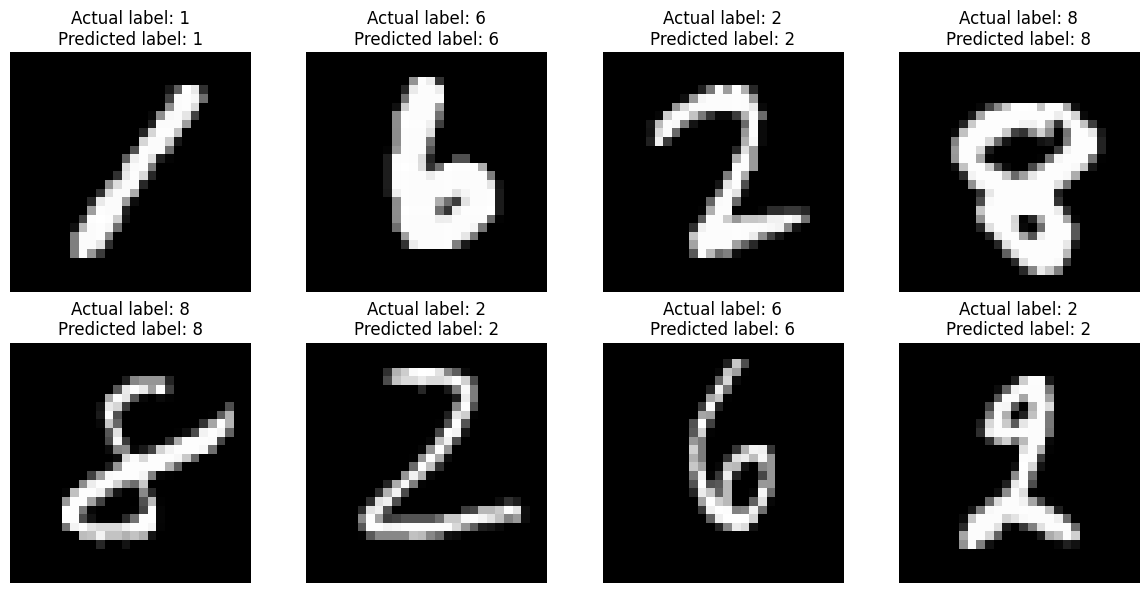

In [66]:
# Display image and label
def visualizePrediction(test_loader, model):
  test_images, test_labels = next(iter(test_loader))
  pred=model(test_images)

  fig, axes = plt.subplots(2, 4, figsize=(12, 6))
  # Show a 2x4 grid of images from test dataset and prediction on them
  for i in range(batch_size):
    ax = axes[i//4, i%4]

    img = test_images[i].squeeze()
    label = test_labels[i]

    ax.imshow(img, cmap="gray")
    ax.set_title(f"Actual label: {label}\nPredicted label: {pred[i].argmax()}")
    ax.axis("off")

  plt.tight_layout()
  plt.show()

visualizePrediction(test_loader, model)